# CPED/BICPED 関数のパフォーマンス比較

このノートブックでは、`cped` (Copy & Paste Edit Distance) と `bicped` (Bidirectional Copy & Paste Edit Distance) 関数のバックエンド実装のパフォーマンスを比較します。

1.  **Python版**: `backend='python'`
2.  **C++版**: `backend='cpp'`

比較を通じて、各実装の特性と、どのような状況でどの実装が有効であるかを明らかにします。


## 1. セットアップ

必要なライブラリと、`src`ディレクトリからCPED関数をインポートします。

In [1]:
import sys
import os
import timeit
import numpy as np
import matplotlib.pyplot as plt
import random

# Add src directory to path to import cped module
sys.path.append(os.path.abspath(os.path.join("..", "src")))
from repmetric import cped, cped_matrix, bicped, bicped_matrix, CPP_AVAILABLE
from repmetric.util import generate_test_case

# Set random seed for reproducibility
random.seed(42)

# Matplotlibの日本語設定
try:
    import japanize_matplotlib

    japanize_matplotlib.japanize()
except ImportError:
    plt.rcParams["font.family"] = "sans-serif"

## 2. テストデータの生成

パフォーマンス測定のために、複雑さが異なるいくつかのテスト用文字列ペアを生成します。

### 再現性のための注意点

公平なパフォーマンス比較のため、このノートブックでは乱数シードを`42`に固定しています。

乱数は以下の順番で使用されます：
1. **ベンチマーク1用データ**: `generate_test_case` を3回呼び出し、'small', 'medium', 'large' のテストケースを生成します。
2. **ベンチマーク2用データ**: `generate_test_case` を `num_sequences` (10) 回ループで呼び出し、距離行列計算用のシーケンスリストを生成します。

In [2]:
test_cases = {
    "small": generate_test_case(unit_length=5, repeats=5, edits=2),
    "medium": generate_test_case(unit_length=10, repeats=10, edits=5),
    "large": generate_test_case(unit_length=15, repeats=15, edits=8),
}

for name, (x, y) in test_cases.items():
    print(f"Test Case '{name}': len(X)={len(x)}, len(Y)={len(y)}")

Test Case 'small': len(X)=25, len(Y)=15
Test Case 'medium': len(X)=100, len(Y)=120
Test Case 'large': len(X)=225, len(Y)=285


## 3. ベンチマーク1: 1対1のパフォーマンス (Python vs C++)

単一の文字列ペアに対する距離計算の実行速度を比較します。`timeit`を使い、複数回実行した平均時間を測定します。

以下では、同一のテストケースを用いて各距離関数の実装を比較します。

### CPED


In [3]:
cped_results_single = {}
number_of_runs = 20  # timeitの実行回数

for name, (X, Y) in test_cases.items():
    print(f"--- Benchmarking '{name}' case ---")

    # Python版の測定
    time_py = timeit.timeit(lambda: cped(X, Y, backend="python"), number=number_of_runs)

    # C++版の測定
    time_cpp = 0
    if CPP_AVAILABLE:
        # 初回実行でライブラリ読み込み
        cped(X, Y, backend="cpp")
        time_cpp = timeit.timeit(
            lambda: cped(X, Y, backend="cpp"), number=number_of_runs
        )

    cped_results_single[name] = {
        "Python (s)": time_py / number_of_runs,
        "C++ (s)": time_cpp / number_of_runs if CPP_AVAILABLE else 0,
    }

print("\n--- Average Execution Time per Run ---")
for name, times in cped_results_single.items():
    print(
        f"Case '{name}': Python={times['Python (s)']:.6f}s, C++={times['C++ (s)']:.6f}s"
    )

--- Benchmarking 'small' case ---
--- Benchmarking 'medium' case ---


--- Benchmarking 'large' case ---



--- Average Execution Time per Run ---
Case 'small': Python=0.000918s, C++=0.000019s
Case 'medium': Python=0.066227s, C++=0.005052s
Case 'large': Python=0.440648s, C++=0.065401s


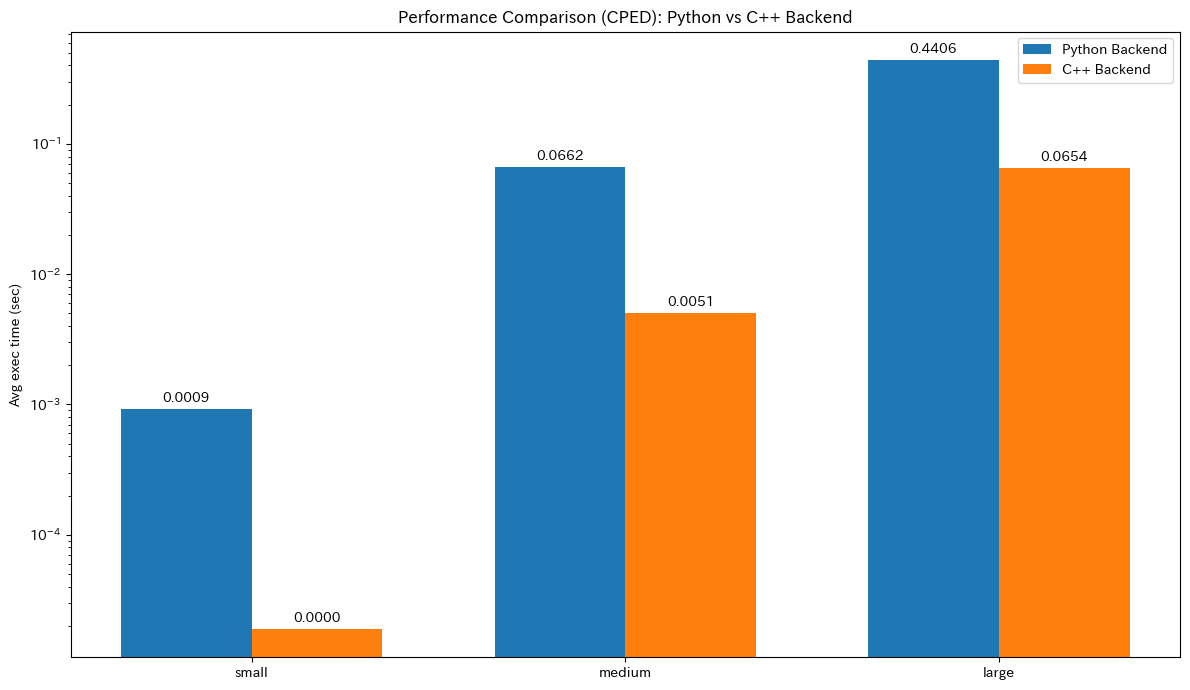

In [4]:
labels = list(cped_results_single.keys())
python_times = [r["Python (s)"] for r in cped_results_single.values()]
cpp_times = [r["C++ (s)"] for r in cped_results_single.values()]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width / 2, python_times, width, label="Python Backend")
rects2 = ax.bar(x + width / 2, cpp_times, width, label="C++ Backend")

ax.set_ylabel("Avg exec time (sec)")
ax.set_title("Performance Comparison (CPED): Python vs C++ Backend")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_yscale("log")  # 時間差が大きいので対数スケール
ax.legend()

ax.bar_label(rects1, padding=3, fmt="%.4f")
ax.bar_label(rects2, padding=3, fmt="%.4f")

fig.tight_layout()
plt.show()

### BICPED

CPED と同じテストケースおよび `number_of_runs` を用いて BICPED の実装を比較します。


In [5]:
bicped_results_single = {}

for name, (X, Y) in test_cases.items():
    print(f"--- Benchmarking '{name}' case (BICPED) ---")

    time_py = timeit.timeit(
        lambda: bicped(X, Y, backend="python"), number=number_of_runs
    )

    time_cpp = 0
    if CPP_AVAILABLE:
        bicped(X, Y, backend="cpp")
        time_cpp = timeit.timeit(
            lambda: bicped(X, Y, backend="cpp"), number=number_of_runs
        )

    bicped_results_single[name] = {
        "Python (s)": time_py / number_of_runs,
        "C++ (s)": time_cpp / number_of_runs if CPP_AVAILABLE else 0,
    }

print("\n--- Average Execution Time per Run (BICPED) ---")
for name, times in bicped_results_single.items():
    print(
        f"Case '{name}': Python={times['Python (s)']:.6f}s, C++={times['C++ (s)']:.6f}s"
    )

--- Benchmarking 'small' case (BICPED) ---
--- Benchmarking 'medium' case (BICPED) ---


--- Benchmarking 'large' case (BICPED) ---



--- Average Execution Time per Run (BICPED) ---
Case 'small': Python=0.002247s, C++=0.000076s
Case 'medium': Python=0.156895s, C++=0.012438s
Case 'large': Python=1.059544s, C++=0.147202s


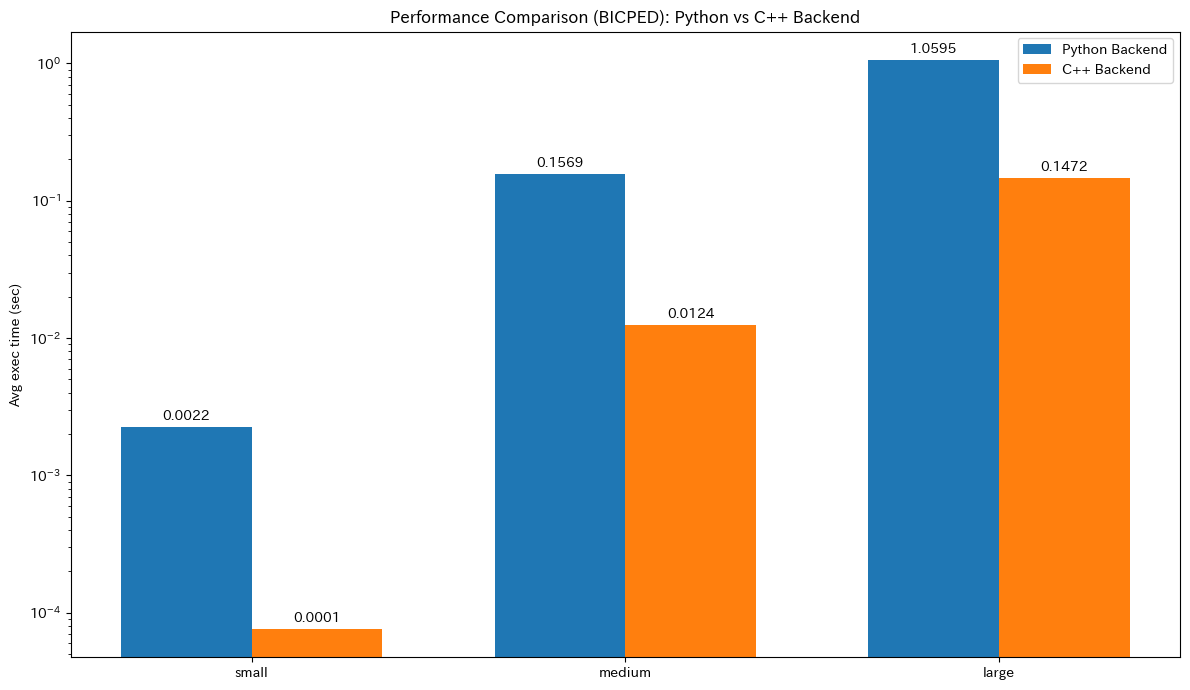

In [6]:
labels = list(bicped_results_single.keys())
python_times = [r["Python (s)"] for r in bicped_results_single.values()]
cpp_times = [r["C++ (s)"] for r in bicped_results_single.values()]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width / 2, python_times, width, label="Python Backend")
rects2 = ax.bar(x + width / 2, cpp_times, width, label="C++ Backend")

ax.set_ylabel("Avg exec time (sec)")
ax.set_title("Performance Comparison (BICPED): Python vs C++ Backend")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_yscale("log")
ax.legend()

ax.bar_label(rects1, padding=3, fmt="%.4f")
ax.bar_label(rects2, padding=3, fmt="%.4f")

fig.tight_layout()
plt.show()

## 4. ベンチマーク2: 行列計算のパフォーマンス (Python vs C++)

複数のシーケンスからなるリスト全体の距離行列を計算する際のパフォーマンスを比較します。

すべての比較で、前節で生成した同じシーケンスリストを利用します。

### CPED


In [7]:
# 行列計算用のシーケンスリストを生成
num_sequences = 20
sequences = [generate_test_case(10, 10, 3)[1] for _ in range(num_sequences)]
print(f"{num_sequences}本のシーケンスを生成しました。 (各 約{len(sequences[0])}文字)")

20本のシーケンスを生成しました。 (各 約110文字)


In [8]:
cped_results_matrix = {}

# 1. Pythonバックエンド
start_time = timeit.default_timer()
matrix_py = cped_matrix(sequences, backend="python")
cped_results_matrix["Python Backend"] = timeit.default_timer() - start_time

# 2. C++バックエンド
time_cpp_matrix = 0
if CPP_AVAILABLE:
    start_time = timeit.default_timer()
    matrix_cpp = cped_matrix(sequences, backend="cpp")
    time_cpp_matrix = timeit.default_timer() - start_time
else:
    print("C++ backend is not available. Falling back to Python timings.")
cped_results_matrix["C++ Backend"] = time_cpp_matrix

print("--- Total Execution Time for Matrix Calculation (CPED) ---")
for name, duration in cped_results_matrix.items():
    print(f"{name}: {duration:.4f}s")

--- Total Execution Time for Matrix Calculation (CPED) ---
Python Backend: 21.6182s
C++ Backend: 0.1963s


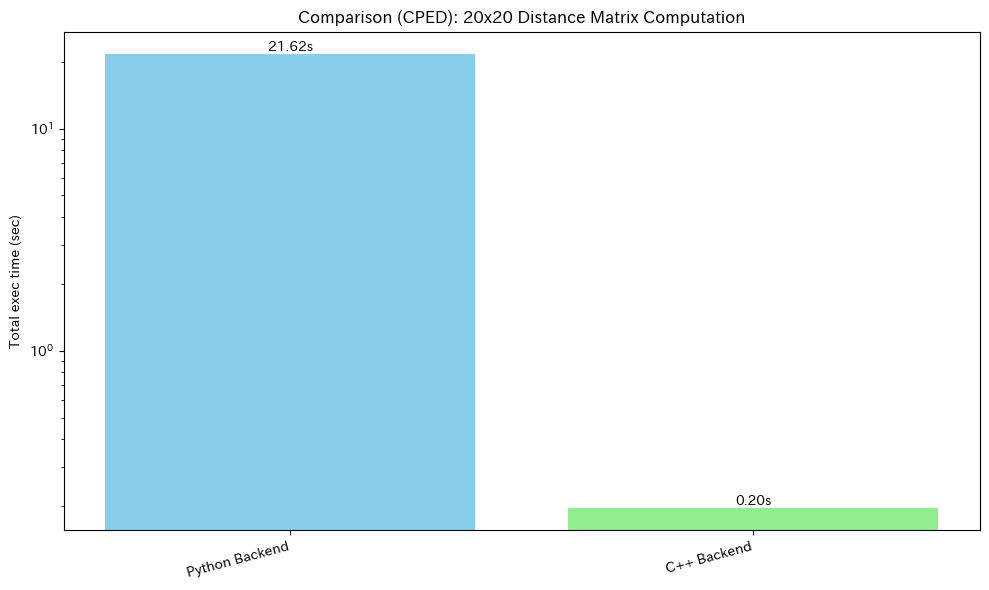

In [9]:
labels = list(cped_results_matrix.keys())
times = list(cped_results_matrix.values())

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(labels, times, color=["skyblue", "lightgreen"])

ax.set_ylabel("Total exec time (sec)")
ax.set_yscale("log")
ax.set_title(
    f"Comparison (CPED): {len(sequences)}x{len(sequences)} Distance Matrix Computation"
)
ax.bar_label(bars, fmt="%.2fs")

plt.xticks(rotation=15, ha="right")
fig.tight_layout()
plt.show()

### BICPED

行列計算でも同一のシーケンス群を使い、BICPED の Python/C++ 実装を比較します。


In [10]:
bicped_results_matrix = {}

start_time = timeit.default_timer()
matrix_py = bicped_matrix(sequences, backend="python")
bicped_results_matrix["Python Backend"] = timeit.default_timer() - start_time

time_cpp_matrix = 0
if CPP_AVAILABLE:
    start_time = timeit.default_timer()
    matrix_cpp = bicped_matrix(sequences, backend="cpp")
    time_cpp_matrix = timeit.default_timer() - start_time
else:
    print("C++ backend is not available. Falling back to Python timings.")
bicped_results_matrix["C++ Backend"] = time_cpp_matrix

print("--- Total Execution Time for Matrix Calculation (BICPED) ---")
for name, duration in bicped_results_matrix.items():
    print(f"{name}: {duration:.4f}s")

--- Total Execution Time for Matrix Calculation (BICPED) ---
Python Backend: 45.8392s
C++ Backend: 0.3324s


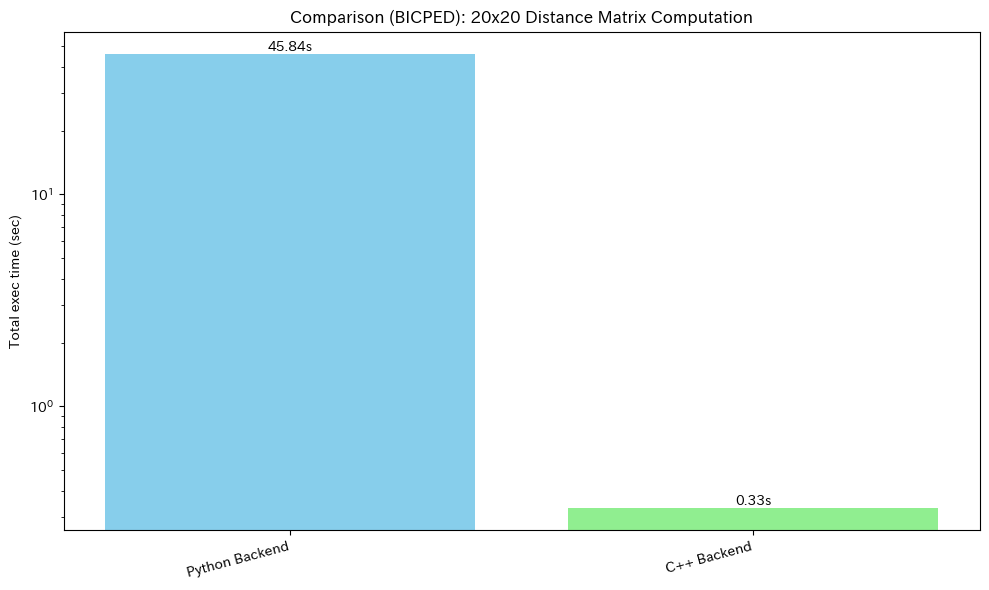

In [11]:
labels = list(bicped_results_matrix.keys())
times = list(bicped_results_matrix.values())

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(labels, times, color=["skyblue", "lightgreen"])

ax.set_ylabel("Total exec time (sec)")
ax.set_yscale("log")
ax.set_title(
    f"Comparison (BICPED): {len(sequences)}x{len(sequences)} Distance Matrix Computation"
)
ax.bar_label(bars, fmt="%.2fs")

plt.xticks(rotation=15, ha="right")
fig.tight_layout()
plt.show()

## 5. 結論

ベンチマークの結果から、以下のことが分かります。

1.  **C++は非常に効果的**: CPED・BICPED ともに、1対1の計算と行列計算の両方において、C++バックエンドはPythonバックエンドに比べて劇的に高速です。文字列が長くなるほど、その差は顕著になります。
2.  **並列化はC++実装で**: C++実装は内部でネイティブスレッドを利用して並列化されており、大規模な行列計算で非常に高いパフォーマンスを発揮します。
3.  **距離関数ごとの傾向は類似**: BICPED でも CPED と同様の性能傾向が見られ、用途に応じて同じ戦略を適用できます。

したがって、パフォーマンスが重要視される場面では、C++バックエンド（`backend='cpp'`）を積極的に使用することが推奨されます。
